In [71]:
%%javascript
// iPython Notebook jumble, please ignore
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<div id="toc"></div>

## Preface

In this notebook, all the steps involved in computing Harmonic Pitch Class Profile or HPCP features are illustrated.

HPCP features are a type of chroma features, distinct in that they are based on spectral peaks, and because harmonic frequencies are summed together, among other contributions.

The HPCP algorithm is implemented following Gomez' original proposal as close as possible [1], with some details borrowed from the summary in [2]. It involves seven main transformations (tuning frequency estimation not included):

1. spectrogram computation
1. discarding frequencies below `f_min` and above `f_max`
1. thresholding the spectrogram with a global and local (frame-wise) threshold
1. applying peak interpolation to obtain hi-res spectral peaks
1. computing a multi-octave pitch profile based on these peaks
1. summing together harmonics
1. folding to a single-octave HPCP

The code is completely vectorized (no for loops). Scipy is used to read audio, compute the spectrum, construct the sparse multidimensional pitch profile, and for efficient convolution, Numpy is used throughout.

[1] Gomez, E. (2006). Tonal Description of Musical Audio Signals. PhD Thesis, Universitat Pompeu Fabra, Spain

[2] Salamon, J., Gómez, E., & Bonada, J. (2011). Sinusoid extraction and
salience function design for predominant melody estimation. In Proc. 14th
Int. Conf. on Digital Audio Effects (DAFx-11), Paris, France (pp. 73–80).
Retrieved from http://recherche.ircam.fr/pub/dafx11/Papers/14_e.pdf

### Dependencies

In [72]:
import numpy as np
from scipy.io import wavfile
from scipy.sparse import coo_matrix
from scipy.signal import convolve2d, spectrogram
import matplotlib.pyplot as plt
%matplotlib inline

### HPCP parameters

In [73]:
file_name = 'rick.wav'
win_size = 4096
hop_size = 1024
window = 'blackman'
precision = 'float32'
f_min = 100
f_max = 5000
global_thr = 80  # in dB below the highest peak
local_thr = 30  # in dB below the highest peak
bins_per_octave = 120
whitening = True
filter_width = 1/3.  # in octaves
harmonic_decay = 0.6
harmonic_tolerance = 2/3.  # in semitones
norm_frames = True
final_thr = 0.5

### Vizualization parameters

In [74]:
example_frame = 20
n_example_frames = 430  # 430 ~ 10s @ hop_size=1024
cmap = 'hot'

def plot_spectrogram(X, max_frames=None, cmap='hot'):
    plt.imshow(X[:max_frames].T, interpolation='nearest', origin='lower', aspect='auto', cmap=cmap)

## HPCP

### Compute spectrogram

In [75]:
def read_audio(file_name):
    sr, y = wavfile.read(file_name)
    if len(y.shape) > 1:  # stereo
        y = np.mean(y, axis=1)
    y = y/np.max(y)
    return y, sr

y, sr = read_audio(file_name)

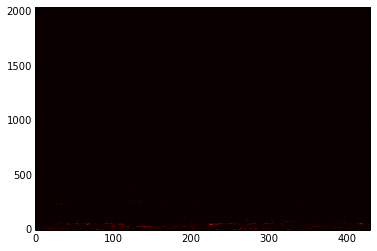

In [76]:
def stft(x, sr, win_size=4096, hop_size=1024, window='blackman', precision='float32'):
    f, t, X = spectrogram(x, sr, nperseg=win_size, noverlap=win_size-hop_size, window=window)
    X = X.astype(precision).T
    k = np.arange(len(f))
    return X, f, k, t

Y, f, k, t = stft(y, sr, win_size=win_size, hop_size=hop_size, window=window, precision=precision)
    
plot_spectrogram(Y, n_example_frames, cmap=cmap)

Scipy's spectrogram is much more efficient but, for the sake of demonstration, here's a one line
spectrogram function that doesn't use scipy:

`X = np.array([np.fft.fft(np.hamming(win_size) * x[start:start+win_size]) for start in range(0, x.shape[0]-win_size, hop_size)])`

### Prune spectrogram to [f_min, f_max]

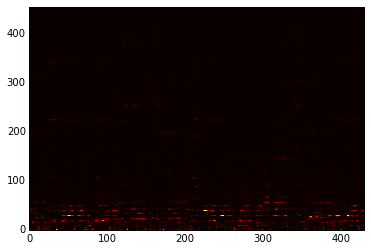

In [77]:
def prune_spectrogram(X, f, f_min=100, f_max=5000):
    band = np.all([f > f_min, f < f_max], axis=0)
    return X[:, band], k[band], f[band]

Y_lim, k, f = prune_spectrogram(Y, f, f_min=f_min, f_max=f_max)

plot_spectrogram(Y_lim, n_example_frames, cmap=cmap)

### Threshold spectrogram based on dB magnitudes

The local thresholding step wasn't something I planned on implementing, but checking Justin Salamon's paper on salience functions, I realized I could add this and make this chromagram pretty much exactly like the UPF's HPCP implementation.

In [78]:
def dB(x):
    return 20.0*np.log10(x)

Y_dB = dB(Y_lim)

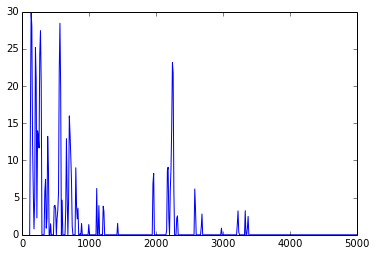

In [79]:
def global_thresholding(X, thr):
    X = X - np.max(X) + thr
    X[X < 0] = 0
    return X

def local_thresholding(X, local_thr):
    X = X - np.max(X, axis=1).reshape(-1,1) + local_thr
    X[X < 0] = 0
    return X

Y_thr = global_thresholding(Y_dB, global_thr)

if local_thr < global_thr:
    Y_thr = local_thresholding(Y_thr, local_thr=local_thr)

plt.plot(f, Y_thr[example_frame])
# plot_spectrogram(Y_thr, n_example_frames, cmap=cmap)

### Apply peak interpolation

There are several ways one can get pitch information at a resolution that is good enough for constant-Q-like applications.

Some options are:
- constant-Q transforms
- hybrid, multi-resolution STFT's
- spectral peak interpolation
- instantaneous frequency (IF) estimation

In [2], peak interpolation and IF are shown to do well in estimating a
pitch salience function.

This implementation uses peak interpolation, as it's also the proposed method in
Gomez' original PhD thesis, and reasonably simple to implement.

In this approach, a parabola is fit to each spetral peak in order to refine
its frequency and dB amplitude.

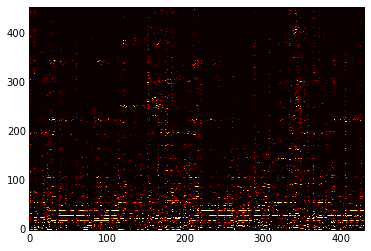

In [80]:
def spectral_peaks(X, k, sr, win_size):

    n_frames, n_bins = X.shape
    precision = X.dtype

    A1 = np.zeros((n_frames, n_bins), dtype=precision)
    A2 = np.zeros((n_frames, n_bins), dtype=precision)
    A3 = np.zeros((n_frames, n_bins), dtype=precision)
    A1[:,1:-1] = X[:,:-2]
    A2[:,1:-1] = X[:,1:-1]
    A3[:,1:-1] = X[:,2:]
    peaks = np.all([A2>A1, A2>A3], axis=0)

    # bin number of each peak
    K = k * peaks

    # compute deviations D of spectral peaks, in bins
    D = np.zeros((n_frames, n_bins), dtype=precision)
    D[peaks] = .5 * (A1[peaks] - A3[peaks]) / (A1[peaks] - 2*A2[peaks] + A3[peaks])

    # compute adjusted frequencies and amplitudes
    F = bin2hz(K + D, sr, win_size)
    A = np.zeros((n_frames, n_bins), dtype=precision)
    A[peaks] = A2[peaks] - D[peaks]/4*(A1[peaks]-A3[peaks])

    return A, F, peaks

def bin2hz(k, sr, win_size):
    return k*sr/win_size

Y_pks, F, peaks = spectral_peaks(Y_thr, k, sr, win_size)

plot_spectrogram(Y_pks, n_example_frames, cmap=cmap)

### Compute multi-octave pitch profile based on linear magnitudes

In [81]:
def lin_mag(x, x_max):
    return 10**((x - x_max)/20)

Y_lin = lin_mag(Y_pks, global_thr)

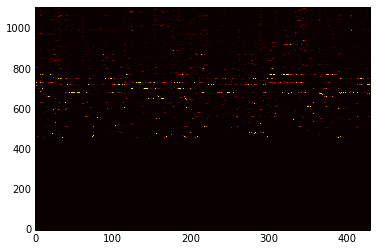

In [82]:
def pitch_profile(X, F, peaks, bins_per_octave):
    n_frames, n_bins = X.shape
    
    T = np.ones((n_frames, n_bins)) * np.arange(n_frames).reshape((-1, 1))  # t in frames, not seconds
    pitch = hz2midi(F)
    pitch_in_bins = bins_per_octave * pitch / 12
    pp = coo_matrix((X[peaks], (T[peaks], pitch_in_bins[peaks])))
    return pp.toarray()
    
def hz2midi(f):
    m = np.zeros(f.shape)
    m[f>0] = 69 + 12.*np.log2(f[f>0]/440)
    return m
    
pp = pitch_profile(Y_lin, F, peaks, bins_per_octave)

plot_spectrogram(pp, n_example_frames, cmap=cmap)

Spectral whitening helps build in some timbre-invariance in chroma features.
Here, I perform whitening in the log-frequency domain instead of the linear
frequency domain, as others do.

My motivation: Müller has proposed a timbre-invariant chromagram in which
the spectrum is high-pass filtered on the Mel scale. (More specifically, he
computes MFCC's, sets the lowest coefficients to zero, and converts back.)

The mel scale on which MFCC's are based, is supposed to be part linear, part
logarithmic, but in practice it is typically more logarithmic. Hence also
my choice to include a timbre-invariance step here rather then earlier.

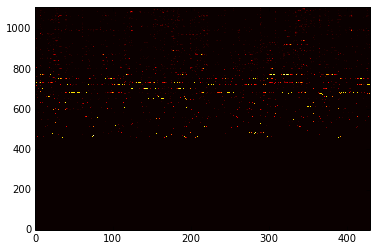

In [83]:
def whiten(X, bins_per_octave, filter_width=1/3.):
    filter_width_bins = int(bins_per_octave * filter_width)
    filter_kernel = np.ones((1, filter_width_bins), dtype=X.dtype)
    filter_kernel = filter_kernel / np.sum(filter_kernel)
    X = X - convolve2d(X, filter_kernel, mode='same')
    X[X < 0] = 0
    return X

if whitening:
    pp = whiten(pp, bins_per_octave=bins_per_octave, filter_width=filter_width)
        
plot_spectrogram(pp, n_example_frames, cmap=cmap)

### Apply harmonic summation

Harmonics are summed together in the log-frequency domain, since this allows for an efficient implementation using convolution.

As proposed by Gomez and formalized again in [1] (above), harmonics are weighted according to:

- their harmonic number `n = round(f/f0)`
- their harmonic deviation `d = f/f0 - n`

Weight `w_n(n)` is given by a geometric series `w = r^n`.

Weight `w_d(d)` is given by a `cos^2` window.

The total weight is simply `w(n,d) = w_n(n) * w_d(d)`.

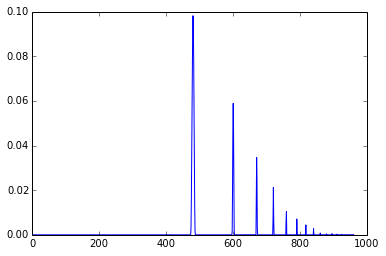

In [84]:
def harmonic_summation_kernel(harmonic_decay=.6, harmonic_tolerance=1, bins_per_octave=120, n_octaves=4):
    """ Make a kernel for summing of harmonic frequencies.

    param: harmonic_decay
        decay rate of weights of harmonics
    param: harmonic_tolerance
        width of the cosine-weighted window around each of the harmonics
    param: bins_per_octave
    param: n_octaves
        number of octaves to include in the kernel (4 or 5 should be enough to
        include most harmonics).
    """

    # f/f0 (log, in octaves) for a linspace of constant Q bins symmetrically around f0
    f_ratio_octaves = 1. * np.arange(-n_octaves*bins_per_octave, n_octaves*bins_per_octave+1) / bins_per_octave

    # f/f0 (in Hz)
    f_ratio = 2**f_ratio_octaves

    # harmonic number and harmonic deviation
    n_harm = np.round(f_ratio)
    d_harm = abs(f_ratio - n_harm)

    w = attenuation(n_harm, r=harmonic_decay) * cosine_window(d_harm, tol=harmonic_tolerance)
    return w / np.sum(w)

def attenuation(n, r=.6):
    """ compute weight of harmonics.
    weights decay exponentially with the harmonic number n, at rate r
    param: n
        array of harmonic numbers
    param: r
        decay rate of weights
    """
    n = np.array(np.round(n))
    w = np.zeros(n.shape)
    w[n>0] = r**(n[n>0]-1)
    return w

def cosine_window(d, tol=1.):
    """
    param: tol
        harmonic_tolerance (in semitones, default=1), i.e.,
        width of the cosine-weighted window around each of the harmonics
    """
    width = np.log(2**(tol/12.))
    w = np.zeros(d.shape)
    w[d < width] = np.cos(d[d < width]*(np.pi/2)/width)**2
    return w

w = harmonic_summation_kernel(harmonic_decay=harmonic_decay,
                                  harmonic_tolerance=harmonic_tolerance,
                                  bins_per_octave=bins_per_octave)
plt.plot(w)

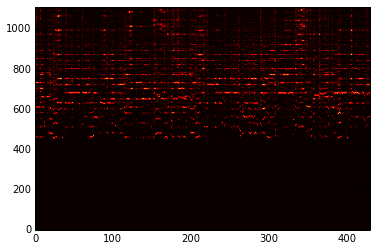

In [85]:
def sum_harmonics(X, harmonic_decay=.6, harmonic_tolerance=1, bins_per_octave=120):
    k = harmonic_summation_kernel(harmonic_decay=harmonic_decay,
                                  harmonic_tolerance=harmonic_tolerance,
                                  bins_per_octave=bins_per_octave)
    k = k.astype(X.dtype)
    return convolve2d(X, k.reshape((1,-1)), mode='same')

hpp = sum_harmonics(pp, harmonic_decay=harmonic_decay,
                        harmonic_tolerance=harmonic_tolerance,
                        bins_per_octave=bins_per_octave)

plot_spectrogram(hpp, n_example_frames, cmap=cmap)

### Fold to chromagram / HPCP

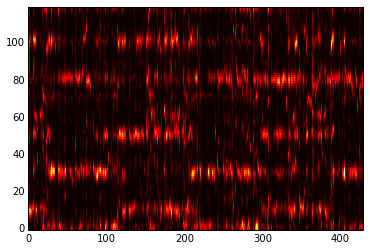

In [86]:
def fold_octaves(X, bins_per_octave):
    n_frames, n_bins = X.shape
    folds = np.arange(0, n_bins, bins_per_octave)
    return np.array([X[:,fold:fold+bins_per_octave] for fold in folds[:-1]]).sum(axis=0)

hpcp = fold_octaves(hpp, bins_per_octave=bins_per_octave)

plot_spectrogram(hpcp, n_example_frames, cmap=cmap)

In my experience, a final thresholding step adds clarity.

Perhaps because thresholding is so easy when all values are [0, 1].

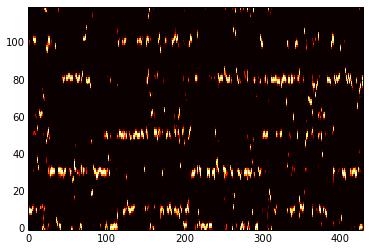

In [87]:
def normalize_frames(X, thr=0.):
    X = X - np.min(X, axis=1).reshape((-1,1))
    X_max = np.max(X, axis=1)
    X = X[X_max >0] / (X_max[X_max > 0]).reshape((-1,1))
    if thr > 0:
        X = (1-thr) * (X-thr) * (X>thr)
    return X

if norm_frames:
    hpcp = normalize_frames(hpcp, thr=final_thr)

plot_spectrogram(hpcp, n_example_frames, cmap=cmap)

In [88]:
print hpcp.dtype

float32


## 12-bin HPCP

In [97]:
import HPCP
import json

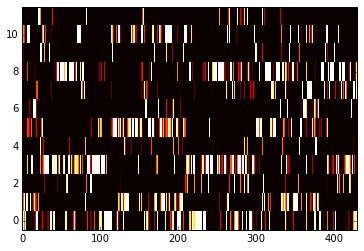

In [100]:
hpcp = HPCP.hpcp(file_name, bins_per_octave=12, precision=precision, output='numpy')

plot_spectrogram(hpcp, n_example_frames, cmap=cmap)

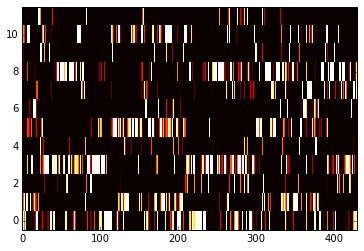

In [101]:
hpcp_json = HPCP.hpcp(file_name, bins_per_octave=12, precision=precision, output='json')
hpcp_dict = json.loads(hpcp_json)
hpcp_list = hpcp_dict['chroma']
hpcp = np.array(hpcp_list, dtype=precision)

plot_spectrogram(hpcp, n_example_frames, cmap=cmap)

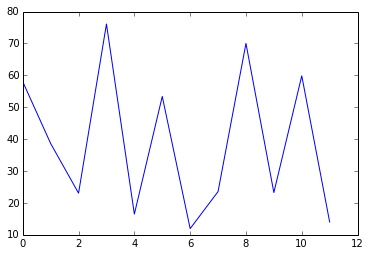

In [102]:
plt.plot(hpcp.sum(axis=0))